Using pyiron with an ASE calculator
===================================

By: John Kitchin and Liam Huber

This notebook uses an `ase.calculators.emt` to compute equations of state for metals in different crystal structures using `pyiron`. We show how to setup  a custom Job for this purpose, how to run the jobs, and later how to do analysis.

The EMT calculator only works for Cu, Ag, Au, Ni, Pd, Pt and Al, and is most accurate for the bulk fcc structure. It is a pure Python calculator that is fast, and part of `ase` so we use it for this example because it is convenient.

This tutorial covers:
1. Setting up the custom Job class
2. Running a calculation and retrieving data from it
3. Running a Murnaghan calculation and retrieving data from it
4. Running a set of Murnaghan equations and retrieving data from them.

# Setup the job class

We have to create a Job class for running these jobs. See the comments below for some explanations of each part. Usually this code would go into a library that is imported. We show it here as an example.

In [1]:
from pyiron_base import PythonTemplateJob
from pyiron_atomistics import Project, Atoms 
from pyiron import ase_to_pyiron

# Our Atoms inherit from ASE.Atoms, so you can use it directly
import ase
from ase.calculators.emt import EMT

class EMTJob(PythonTemplateJob):
    def __init__(self, project, job_name):
        super(EMTJob, self).__init__(project, job_name)
        # The template job comes with `input` and `output` attributes that will  
        # handle all the (de)serialization for you
        self.input.atoms = pr.atomistics.structure.bulk('Cu')  # Or whatever default
        # self.output.energy = None  # Let's just populate the field for now
        
    @property
    def structure(self):
        """
        'structure' is the canonical name for an `Atoms` object in pyiron.
        The Murnhaghan job is expecting a `structure` attribute on its input jobs.
        """
        return self.input.atoms
    
    @structure.setter
    def structure(self, structure: Atoms):
        if isinstance(structure, Atoms):            
            self.input.atoms = structure
        # I find it helpful to be able to use ase.atoms.Atoms directly
        elif isinstance(structure, ase.atoms.Atoms):
            self.input.atoms = ase_to_pyiron(structure)
        else:
            raise TypeError(f"Expected an Atoms object but got {type(structure)}")
        
    def run_static(self):
        """
        `run` is actually already a method higher up the job inheritence tree,
        it does things like let the project know the job exists -- this is why you 
        weren't seeing the job in `job_table`.
        What we actually want to define is `run_static`.
        ...This definitely needs to be better documented!!! (Actually, the whole 
        run paradigm needs some work to make it simpler and clearer, but documentation
        would be a good enough start!)
        """
        print("RUNNING")
        self.structure.set_calculator(EMT())
        self.output.volume = self.structure.get_volume()
        self.output.energy = self.structure.get_potential_energy()
        # With the output attribute, all we need to do is tell the job to
        # write itself:
        self.to_hdf()
        
        # Buuuuut, the Murnhaghan job doesn't know about this functionality,
        # so we still need to use the old-school way of writing directly to a
        # particular place in the HDF. Note that Murnhaghan looks at "energy_pot"
        # not just "energy". It also expects that value to be a list of energies.
        # Murn is also expecting a (list of) volume(s) stored in a particular place,
        # so we'll write that too
        with self.project_hdf5.open("output/generic") as h5out: 
            h5out["energy_pot"] = [self.output.energy]
            h5out["volume"] = [self.structure.get_volume()]
                    
        # Ok, now we're really done
        self.status.finished = True

2022-12-22 16:53:11,306 - pyiron_log - WARNING - Configuration file may be read by others - check permissions to secure credential information!
/Users/jkitchin/opt/anaconda3/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 4.0.0-unsupported is an invalid version and will not be supported in a future release
  warnings.warn(


# Run a single calculation

We make a project, and remove any jobs in it. 

```{warning}
This is destructive, and only done here for reproducibility and so we start with a clean project. 
```

In [2]:
pr = Project('emt_one')
pr.remove_jobs(silently=True, recursive=True)

Now we create a job, add the structure, and run it. This creates a directory called `emt_one` with a file in it `Al_1.h5`.

In [3]:
job = pr.create_job(job_type=EMTJob, job_name="Al")
job.structure = pr.atomistics.structure.bulk("Al")
job.run()
print(job.output.energy)

The job Al was saved and received the ID: 50
RUNNING
-0.001502047586230404


Suppose it is later, and it is time for analysis. We can load the job and get information from the job by its name.

In [4]:
pr_later = Project('emt_one')

loaded = pr_later.load("Al")
print(loaded.output.volume, loaded.output.energy)
# The job shows up in the job table, and can be loaded later

16.60753125 -0.001502047586230404


You can see the jobs that are in the project here.

In [5]:
pr_later.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,50,finished,None,Al,/Al,None,/Users/jkitchin/Desktop/pyiron/notebooks/emt_one/,2022-12-22 16:53:19.671184,None,None,pyiron@Johns-iMac-4.local#1,EMTJob,0.4,None,None


We don't need this project for anything further, so you can delete it.  This is also destructive!

In [6]:
pr_later.remove_jobs(silently=True, recursive=True)
pr_later.remove(enable=True)

  0%|          | 0/1 [00:00<?, ?it/s]

# Do a Murnaghan job

We will now run a Murnaghan Job that computes the equation of state for Cu. We make a new project for this. That will create a new directory, `emt_murn`. When you run this, it will run each volume automatically, and save these results in a folder inside emt_murn.

Again we delete any jobs that might exist so we start clean here.

The job murn was saved and received the ID: 50
The job murn_0_9 was saved and received the ID: 51
RUNNING
The job murn_0_95 was saved and received the ID: 52
RUNNING
The job murn_1_0 was saved and received the ID: 53
RUNNING
The job murn_1_05 was saved and received the ID: 54
RUNNING
The job murn_1_1 was saved and received the ID: 55
RUNNING


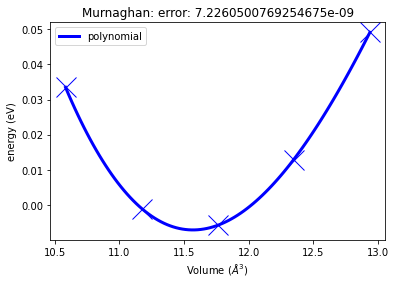

In [7]:
pr = Project('emt_murn')
pr.remove_jobs(silently=True, recursive=True)

job = pr.create_job(job_type=EMTJob, job_name="Cu")
job.structure = pr.atomistics.structure.bulk("Cu")

murn = pr.atomistics.job.Murnaghan("murn")
murn.ref_job = job
murn.input["num_points"] = 5  
murn.run()
murn.plot();  # Looks right for me!

# Analysis later

We can load the project and see the job table.

In [8]:
pr_later = Project('emt_murn')
pr_later.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,50,finished,Cu,murn,/murn,None,/Users/jkitchin/Desktop/pyiron/notebooks/emt_murn/,2022-12-22 16:53:20.136957,2022-12-22 16:53:21.818205,1.0,pyiron@Johns-iMac-4.local#1#5/5,Murnaghan,0.3.0,None,NaN
1,51,finished,None,murn_0_9,/murn_0_9,None,/Users/jkitchin/Desktop/pyiron/notebooks/emt_murn/murn_hdf5/,2022-12-22 16:53:20.368397,NaT,NaN,pyiron@Johns-iMac-4.local#1,EMTJob,0.4,None,50.0
2,52,finished,None,murn_0_95,/murn_0_95,None,/Users/jkitchin/Desktop/pyiron/notebooks/emt_murn/murn_hdf5/,2022-12-22 16:53:20.682500,NaT,NaN,pyiron@Johns-iMac-4.local#1,EMTJob,0.4,None,50.0
3,53,finished,None,murn_1_0,/murn_1_0,None,/Users/jkitchin/Desktop/pyiron/notebooks/emt_murn/murn_hdf5/,2022-12-22 16:53:20.988416,NaT,NaN,pyiron@Johns-iMac-4.local#1,EMTJob,0.4,None,50.0
4,54,finished,None,murn_1_05,/murn_1_05,None,/Users/jkitchin/Desktop/pyiron/notebooks/emt_murn/murn_hdf5/,2022-12-22 16:53:21.340712,NaT,NaN,pyiron@Johns-iMac-4.local#1,EMTJob,0.4,None,50.0
5,55,finished,None,murn_1_1,/murn_1_1,None,/Users/jkitchin/Desktop/pyiron/notebooks/emt_murn/murn_hdf5/,2022-12-22 16:53:21.645413,NaT,NaN,pyiron@Johns-iMac-4.local#1,EMTJob,0.4,None,50.0


You can retrieve a job with its name. Here we do that and run the plot function from it. We also extract some data from the job output.

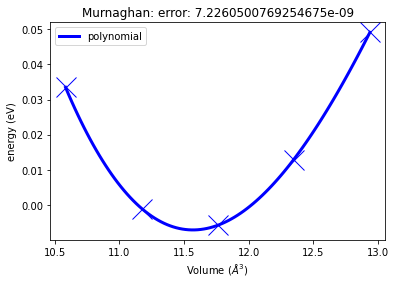

(11.569621624092406, -0.007142587829461533)

In [9]:
j = pr_later['murn']
p = j.plot()
j['output/equilibrium_volume'], j['output/equilibrium_energy']

This shows the volumes and energies that go into the equation of state.

In [10]:
j['output/volume'], j['output/energy']

(array([10.58532322, 11.17339674, 11.76147025, 12.34954376, 12.93761727]),
 array([ 0.03348436, -0.00111829, -0.00568151,  0.01286093,  0.0491656 ]))

# Loop over metals and structures

Finally, we are ready to get to the task. We want to build a table that shows the equilibrium volume for Cu, Ag, and Au in two different crystal structures. We setup a nested loop over these to run the calculations.

For each metal we set the initial volume to be equal to the ground state fcc equilibrium volume. This is to make sure we find a minimum in the equation of state. It takes some cleverness to do this. The `bulk` function requires a lattice constant for non-groundstate structures, which we don't know. We just set a=1 (which is much to small) and then scale the cell volume to get the ground state atomic volume in each structure.

We use f-strings to automatically create the job names.

In [11]:
pr = Project('emt_murn')

for m in ['Cu', 'Ag', 'Au']:
    for s in ['fcc', 'bcc']:
        ref = pr.atomistics.structure.bulk(m)
        expV = ref.get_volume() / len(ref) # atomic volume / atom

        atoms = pr.atomistics.structure.bulk(m, s, a=1)
        natoms = len(atoms)
        V = atoms.get_volume()

        # Now we rescale so the atoms have about the same volume as the ground state case        
        f = expV * natoms / V
        atoms.set_cell(atoms.get_cell() * f**(1 / 3), scale_atoms=True)

        job = pr.create_job(job_type=EMTJob, job_name=f"{m}")
        job.structure = atoms

        murn = pr.atomistics.job.Murnaghan(f"murn_{m}_{s}")
        murn.ref_job = job
        murn.input["num_points"] = 5  
        murn.run()

The job murn_Cu_fcc was saved and received the ID: 56
The job murn_Cu_fcc_0_9 was saved and received the ID: 57
RUNNING
The job murn_Cu_fcc_0_95 was saved and received the ID: 58
RUNNING
The job murn_Cu_fcc_1_0 was saved and received the ID: 59
RUNNING
The job murn_Cu_fcc_1_05 was saved and received the ID: 60
RUNNING
The job murn_Cu_fcc_1_1 was saved and received the ID: 61
RUNNING
The job murn_Cu_bcc was saved and received the ID: 62
The job murn_Cu_bcc_0_9 was saved and received the ID: 63
RUNNING
The job murn_Cu_bcc_0_95 was saved and received the ID: 64
RUNNING
The job murn_Cu_bcc_1_0 was saved and received the ID: 65
RUNNING
The job murn_Cu_bcc_1_05 was saved and received the ID: 66
RUNNING
The job murn_Cu_bcc_1_1 was saved and received the ID: 67
RUNNING
The job murn_Ag_fcc was saved and received the ID: 68
The job murn_Ag_fcc_0_9 was saved and received the ID: 69
RUNNING
The job murn_Ag_fcc_0_95 was saved and received the ID: 70
RUNNING
The job murn_Ag_fcc_1_0 was saved and rec

In [12]:
pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,50,finished,Cu,murn,/murn,None,/Users/jkitchin/Desktop/pyiron/notebooks/emt_murn/,2022-12-22 16:53:20.136957,2022-12-22 16:53:21.818205,1.0,pyiron@Johns-iMac-4.local#1#5/5,Murnaghan,0.3.0,None,NaN
1,51,finished,None,murn_0_9,/murn_0_9,None,/Users/jkitchin/Desktop/pyiron/notebooks/emt_murn/murn_hdf5/,2022-12-22 16:53:20.368397,NaT,NaN,pyiron@Johns-iMac-4.local#1,EMTJob,0.4,None,50.0
2,52,finished,None,murn_0_95,/murn_0_95,None,/Users/jkitchin/Desktop/pyiron/notebooks/emt_murn/murn_hdf5/,2022-12-22 16:53:20.682500,NaT,NaN,pyiron@Johns-iMac-4.local#1,EMTJob,0.4,None,50.0
3,53,finished,None,murn_1_0,/murn_1_0,None,/Users/jkitchin/Desktop/pyiron/notebooks/emt_murn/murn_hdf5/,2022-12-22 16:53:20.988416,NaT,NaN,pyiron@Johns-iMac-4.local#1,EMTJob,0.4,None,50.0
4,54,finished,None,murn_1_05,/murn_1_05,None,/Users/jkitchin/Desktop/pyiron/notebooks/emt_murn/murn_hdf5/,2022-12-22 16:53:21.340712,NaT,NaN,pyiron@Johns-iMac-4.local#1,EMTJob,0.4,None,50.0
5,55,finished,None,murn_1_1,/murn_1_1,None,/Users/jkitchin/Desktop/pyiron/notebooks/emt_murn/murn_hdf5/,2022-12-22 16:53:21.645413,NaT,NaN,pyiron@Johns-iMac-4.local#1,EMTJob,0.4,None,50.0
6,56,finished,Cu,murn_Cu_fcc,/murn_Cu_fcc,None,/Users/jkitchin/Desktop/pyiron/notebooks/emt_murn/,2022-12-22 16:53:22.613531,2022-12-22 16:53:24.250932,1.0,pyiron@Johns-iMac-4.local#1#5/5,Murnaghan,0.3.0,None,NaN
7,57,finished,None,murn_Cu_fcc_0_9,/murn_Cu_fcc_0_9,None,/Users/jkitchin/Desktop/pyiron/notebooks/emt_murn/murn_Cu_fcc_hdf5/,2022-12-22 16:53:22.839273,NaT,NaN,pyiron@Johns-iMac-4.local#1,EMTJob,0.4,None,56.0
8,58,finished,None,murn_Cu_fcc_0_95,/murn_Cu_fcc_0_95,None,/Users/jkitchin/Desktop/pyiron/notebooks/emt_murn/murn_Cu_fcc_hdf5/,2022-12-22 16:53:23.148641,NaT,NaN,pyiron@Johns-iMac-4.local#1,EMTJob,0.4,None,56.0
9,59,finished,None,murn_Cu_fcc_1_0,/murn_Cu_fcc_1_0,None,/Users/jkitchin/Desktop/pyiron/notebooks/emt_murn/murn_Cu_fcc_hdf5/,2022-12-22 16:53:23.454056,NaT,NaN,pyiron@Johns-iMac-4.local#1,EMTJob,0.4,None,56.0


# Analysis of the data

We can analyse the data in a variety of ways. Here we retrieve jobs by their names, and extract data from them to make a table of the metals, structures and equilibrium properties. 

It is evident here that the fcc structures are more stable than the bcc structures, and that the atomic volume in each structures is about the same.

In [13]:
pr_later = Project('emt_murn')

data = []
for m in ['Cu', 'Ag', 'Au']:
    for s in ['fcc', 'bcc']:
        job = pr_later[f"murn_{m}_{s}"]
        data += [[m, 
                  s, 
                  job['output/equilibrium_volume'], 
                  job['output/equilibrium_energy']]]
        
import pandas as pd
pd.DataFrame(data, columns=['metal', 'structure', 'V0', 'e0'])
        

,metal,structure,V0,e0
0,Cu,fcc,11.569622,-0.007143
1,Cu,bcc,11.643551,0.025514
2,Ag,fcc,16.782791,-0.000493
3,Ag,bcc,16.870628,0.038996
4,Au,fcc,16.692002,-0.000417
5,Au,bcc,16.785733,0.033893


## Analysis of individual jobs with filtering

You can also setup a `pyiron.Table` using filters and functions on the project.

We filter the job table for Au bcc murnaghan EMT jobs. First we setup two filters. The first is on the job_table to select jobs that are finished and of type EMTJob. The second is a job filter to select jobs specific to murn_Au_bcc.

In [14]:
def db_filter_function(job_table):
    # Returns a pandas Series of boolean values (True for entries that have status finished
    # and hamilton type Murnaghan.)
    return (job_table.status == "finished") & (job_table.hamilton == "EMTJob")

def job_filter_function(job):
    # returns a boolean value if the status of the job
    #is finished and if "murn" is in it's job name
    return "murn_Au_bcc" in job.job_name

Next we define some functions that will extract specific data from a job, in this case the volume and energy_pot.

In [15]:
def get_v(job):
    return job["output/generic/volume"][0]

def get_e(job):
    return job["output/generic/energy_pot"][0]

Finally we create a table, add the filters and functions, then run it to get a Dataframe

In [16]:
table = pr_later.create_table("table")
table.db_filter_function = db_filter_function
table.filter_function = job_filter_function
table.add["volume"] = get_v
table.add["energy"] = get_e


table.run(run_again=True)
df = table.get_dataframe()
df

The job table was saved and received the ID: 92


/var/folders/3q/ht_2mtk52hl7ydxrcr87z2gr0000gn/T/ipykernel_54027/2486510588.py:8: DeprecationWarning: pyiron_base.jobs.job.generic.run(run_again=True) is deprecated. It is not guaranteed to be in service in vers. 0.4.0
  table.run(run_again=True)


Loading and filtering jobs:   0%|          | 0/35 [00:00<?, ?it/s]

Processing jobs:   0%|          | 0/5 [00:00<?, ?it/s]

,job_id,volume,energy
0,87,15.281395,0.122397
1,88,16.130362,0.048870
2,89,16.979328,0.035496
3,90,17.828294,0.064431
4,91,18.677261,0.122571


Now you can do what you want with the Dataframe, e.g. subsequent analysis, plotting, etc...

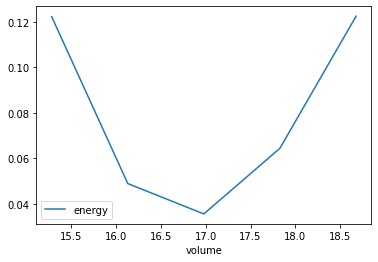

In [17]:
df.plot(x='volume', y='energy');

# Summary

That concludes this tutorial. You could extend it in some additional ways. For example, you might add another structure like hcp or sc to the project, or add some additional metals. You might add a final calculation at the calculated equilibrium volume for each metal and structure.

In [18]:
# All done? You can clean it up like this if you don't want the files around anymore
pr_later.remove_jobs(silently=True, recursive=True)
pr_later.remove(enable=True)

  0%|          | 0/43 [00:00<?, ?it/s]